<a href="https://colab.research.google.com/github/vinayshanbhag/math/blob/master/Linear_Discriminant_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_wine

In [6]:
X, y = load_wine(return_X_y=True)
X.shape, y.shape

((178, 13), (178,))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y,random_state=1)
print("X_train.shape:",X_train.shape,"\ny_train.shape:",y_train.shape,"\nX_test.shape:",X_test.shape,"\ny_test.shape:",y_test.shape)

X_train.shape: (124, 13) 
y_train.shape: (124,) 
X_test.shape: (54, 13) 
y_test.shape: (54,)


### Scale features
$X_{std} = \frac{(X - \mu)}{\sigma}$

In [10]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

### Mean vector for each class

Feature-wise mean across standardized training samples by each output class

In [19]:
import numpy as np
mean_vecs=np.asarray([X_train_std[y_train==label].mean(axis=0) for label in np.unique(y_train)])
print("shape of mean vectors",mean_vecs.shape)
print("mean_vecs[0]:\n",mean_vecs[0])

shape of mean vectors (3, 13)
mean_vecs[0]:
 [ 0.89976216 -0.35996329  0.30103147 -0.74304582  0.46792414  0.91761752
  0.98085519 -0.6287134   0.64032575  0.20178957  0.49581041  0.76416637
  1.16973167]


### Within class scatter matrix

Within class scatter matrix is defined as-

$S_W = \displaystyle\sum_{i=1}^{c} S_i$

where $i$ represents individual class and 

$S_i$ is the individual scatter matrix of class $i$ and is defined as-

$S_i = \frac{1}{n_i}\displaystyle\sum_{x \in D_i} (x-m_i)(x-m_i)^T$

where 

$n_i$ is the number of samples of class $i$

$m_i$ is the mean vector of class $i$ and

$x$ is a vector, a sample from class $i$ of $D$ features.

$S_i \in \mathbb{R}^{D \mathbb{x} D}$

$S_W \in \mathbb{R}^{D \mathbb{x} D}$

$S_W$ is a measure of how samples within a class are spread

In [31]:
d = X_train_std.shape[1] # Number of features
S_W = np.zeros((d,d)) # Initialize to zeros
for label, mv in zip(np.unique(y_train), mean_vecs):
  class_scatter = np.zeros((d,d))
  for row in X_train_std[y_train==label]:
    row, mv = row.reshape(d,1), mv.reshape(d,1)
    class_scatter += (row-mv).dot((row-mv).T)
  class_scatter = class_scatter/len(X_train_std[y_train==label])
  S_W += class_scatter
print("S_W.shape:",S_W.shape)

S_W.shape: (13, 13)


### Between class scatter matrix

Between class scatter matrix is defined as-

$S_B = \displaystyle\sum_{i=1}^{c} n_i(m_i-m)(m_i-m)^T$

where $i$ represents individual class and 

$n_i$ is the number of samples of class $i$

$m_i$ is the mean vector of class $i$, \$m_i \in \mathbb{R}^{D \mathbb{x} 1}$ and

$m$ is the overall mean vector across all classes, \$m \in \mathbb{R}^{D \mathbb{x} 1}$

$S_B \in \mathbb{R}^{D \mathbb{x} D}$

$S_B$ is a measure of how samples across classes are spread

In [36]:
d = X_train_std.shape[1] # Number of features
overall_mean = np.mean(X_train_std, axis=0).reshape(d,1) # overall mean feature vector across all classes
S_B = np.zeros((d,d)) # Initialize to zeros
for label, mean_vec in zip(np.unique(y_train), mean_vecs):
  n = X_train_std[y_train==label].shape[0]
  print(f"Samples in class {label}: {n}")
  mean_vec=mean_vec.reshape(d,1)
  S_B += n*(mean_vec-overall_mean).dot((mean_vec-overall_mean).T)
print("S_B.shape:",S_B.shape)

Samples in class 0: 41
Samples in class 1: 50
Samples in class 2: 33
S_B.shape: (13, 13)


### Eigen Decomposition of $S_W^{-1} \cdot S_B$

Compute $S_W^{-1} \cdot S_B$

Eigen decompose

Sort Eigen values in descending order

Pick the top 2 eigen values and associated eigen vectors

In [47]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [48]:
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
#eigen_pairs

In [64]:
eigen_pairs = sorted(eigen_pairs, key=lambda k:k[0], reverse=True)
print("Sorted eigen values:")
[print(f"{v[0]:0.2e}") for v in eigen_pairs];

Sorted eigen values:
4.06e+02
1.89e+02
4.53e-14
2.85e-14
2.84e-14
2.62e-14
1.67e-14
1.67e-14
7.95e-15
7.95e-15
6.57e-15
6.57e-15
1.69e-15


### Class discrimanatory information in linear discriminants

In [80]:
total_value = eigen_values.real.sum()
disc = [i[0]/total_value for i in eigen_pairs]
cum_disc = np.cumsum(disc)

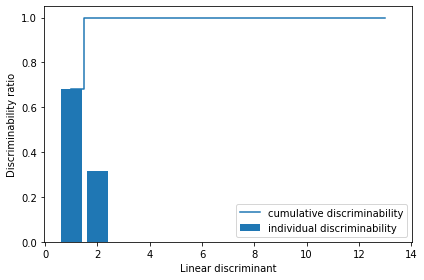

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(1,d+1), disc, align='center', label='individual discriminability');
plt.step(range(1,d+1), cum_disc, where='mid',label="cumulative discriminability");
plt.xlabel('Linear discriminant')
plt.ylabel('Discriminability ratio')
plt.legend();
plt.tight_layout();

### Transformation matrix $W$

Stack eigen vector columns corresponding to the top 2 eigen values

$W \in \mathbb{R}^{D \mathbb{x} 2}$

In [88]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real, eigen_pairs[1][1][:,np.newaxis].real))
w.shape, w

((13, 2), array([[-0.14064935, -0.42024575],
        [ 0.06040622, -0.12190987],
        [ 0.00618927, -0.34261309],
        [ 0.23347392,  0.27281116],
        [-0.01211356, -0.02768843],
        [ 0.18784007, -0.08858725],
        [-0.74681383,  0.45372455],
        [-0.09170678,  0.14531902],
        [ 0.01429136,  0.06746305],
        [ 0.28723517, -0.22447077],
        [-0.10697632,  0.21007505],
        [-0.35276484, -0.00293714],
        [-0.31914504, -0.53107943]]))

### Project features from training data to the two new linear discriminants

$X^{'} = X \cdot W$

$X \in \mathbb{R}^{n \mathbb{x} D}$

$W \in \mathbb{R}^{D \mathbb{x} 2}$

$X^{'} \in \mathbb{R}^{n \mathbb{x} 2}$

In [90]:
X_train_lda = X_train_std.dot(w)
X_train_lda.shape

(124, 2)

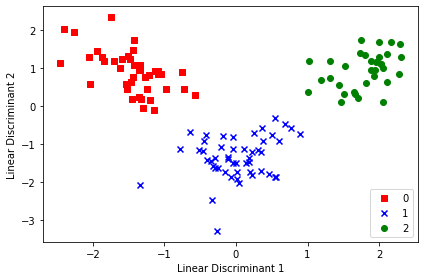

In [91]:
colors=list('rbg')
markers=list('sxo')
for label, color, marker in zip(np.unique(y_train), colors, markers):
  plt.scatter(X_train_lda[y_train==label,0],
              X_train_lda[y_train==label,1]*-1,
              c=color,marker=marker, label=label
              )
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.legend(loc='lower right')
plt.tight_layout()